# Draft of EKF implementation for temporal alignment

Using CTRA model.

Heavily based on [balzer82 implementation](https://github.com/balzer82/Kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb) and [giovannix adaptation](https://github.com/giovannix/kalman/blob/master/Extended-Kalman-Filter-CTRA.ipynb).

In [1]:
from sympy import symbols, Matrix, init_printing
from IPython.display import display

init_printing()

vs, psis, dpsis, dts, xs, ys, lats, lons, axs = symbols('v \psi \dot\psi T x y lat lon a')

hs = Matrix([[xs],
             [ys],
             [psis],
             [vs],
             [dpsis],
             [axs]])

state = Matrix([xs,ys,psis,vs,dpsis,axs])

# Preallocation for Plotting
x0 = []
x1 = []
x2 = []
x3 = []
x4 = []
x5 = []
x6 = []
Zx = []
Zy = []
Px = []
Py = []
Pdx= []
Pdy= []
Pddx=[]
Pddy=[]
Pdv =[]
Kx = []
Ky = []
Kdx= []
Kdy= []
Kddx=[]
Kdv= []
dstate=[]
x_noisy_measurement = []
y_noisy_measurement = []
x_predicted = []
y_predicted = []

In [2]:
def log_state_and_noises(iteration, state, predicted_state, noises, dt):
    updated_state_s, noise_s, sensors_std_s, = symbols('updated\_state noise sensors\_std')
    
    p_x, p_y, p_psi, p_v, p_dotpsi, p_a = symbols('\hat\ x \hat\ y \hat\ \psi \hat\ v \hat{\dot{\psi}} \hat\ a')
    predicted_state_matrix_s = Matrix([p_x, p_y, p_psi, p_v, p_dotpsi, p_a])
    predicted_state_s = symbols('predicted\_state')
    
    print(f'Iteration {iteration}, dt = {dt}:')
    print('='*100)
        
    display(Eq(
        predicted_state_s,
        Eq(
            predicted_state_matrix_s,
            Matrix(predicted_state),
            evaluate=False
        )
    ))
    
    print('-'*100)
    display(Eq(
        updated_state_s,
        Eq(state, Matrix(x), evaluate=False)
    ))
    
    print('*Noise included')  
    print('-'*100)
    
    display(Eq(
        Le(
            -sensors_std_s,
            Le(noise_s, sensors_std_s),
            evaluate=False
        ),
        Le(
            Matrix(-sensors_std),
            Le(Matrix(noises), Matrix(sensors_std), evaluate=False),
            evaluate=False
        )
    ))

    print('='*100)

In [3]:
import numpy as np
from numpy.random import default_rng
from sympy import Matrix, Eq, Le, Ge, symbols, init_printing
from copy import deepcopy
from IPython.display import display

init_printing()

STATE_SIZE = 6 # States
STATE_X_IDX, STATE_Y_IDX, STATE_YAW_IDX, STATE_VELOCITY_IDX, STATE_YAW_RATE_IDX, STATE_ACCELERATION_IDX = range(STATE_SIZE)

# Generated running the loop with correction commented, just with prediction
measurements_mock = np.array([
    [4.0, -2.0, 1.5708, 5.0, 0.4488, 4.0],
    [3.7538, 0.4616, 1.761, 6.6948, 0.4488, 4.0],
    [2.8449, 3.5203, 1.9512, 8.3896, 0.4488, 4.0],
    [1.0564, 6.6834, 2.2174, 8.8133, 0.6283, 1.0],
    [-1.627, 9.3919, 2.4836, 9.237, 0.6283, 1.0],
    [-5.0039, 11.3473, 2.7498, 9.237, 0.6283, 0.0],
    [-8.7762, 12.3455, 3.016, 9.237, 0.6283, 0.0],
    [-12.7749, 13.1978, 2.8496, 10.0844, -0.3927, 2.0],
    [-16.9109, 14.8321, 2.6832, 10.9318, -0.3927, 2.0],
    [-20.7895, 17.6414, 2.3504, 11.7792, -0.7854, 2.0],
    [-23.7432, 21.856, 2.0176, 12.6266, -0.7854, 2.0],
    [-26.3263, 27.2473, 2.0176, 15.5925, 0.0, 7.0],
    [-29.1809, 33.2053, 2.0176, 15.5925, 0.0, 0.0],
])

noises_mock = np.array([
    [-1.044, 1.0289, -0.0145, 0.9013, -0.0183, 0.0579],
    [0.7317, 0.8656, 0.0095, -0.5005, 0.0835, -0.4629],
    [-0.0571, -1.0837, -0.0015, 0.4288, -0.0634, -0.0808],
    [-0.5773, -1.1117, -0.0182, -0.778, 0.0696, -0.4022],
    [0.8567, 1.2855, 0.0112, -0.2399, 0.0904, -0.3941],
    [-0.8416, 0.1583, 0.0063, -0.6525, 0.084, -0.3697],
    [1.1896, -0.95, 0.0111, 0.4016, 0.0349, -0.1406],
    [0.5857, -0.9672, -0.0158, 0.3913, -0.0223, 0.2368],
    [-0.5729, -0.5062, 0.0078, -0.6339, -0.0688, 0.1991],
    [0.2298, 0.2873, -0.0159, 0.0898, -0.0375, -0.3652],
    [-0.2236, 0.5324, -0.0147, -0.1144, 0.0552, 0.3881],
    [0.6675, -0.5955, 0.018, 0.6145, -0.0493, -0.0704],
    [1.391, -1.0449, 0.0106, 0.9431, 0.0677, 0.3961],
])

def predict(x, P, dt):
    noise_pos     = 0.5*8.8*dt**2  # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
    noise_course  = 0.1*dt # assume 0.1rad/s as maximum turn rate for the vehicle
    noise_velocity= 8.8*dt # assume 8.8m/s2 as maximum acceleration, forcing the vehicle
    noise_yawrate = 1.0*dt # assume 1.0rad/s2 as the maximum turn rate acceleration for the vehicle
    noise_accel   = 0.5 # assume 0.5m/s2

    # TODO: Can be improved and calibratred
    Q = np.diag([noise_pos**2, noise_pos**2, noise_course**2, noise_velocity**2, noise_yawrate**2, noise_accel**2])
    
    pos_x, pos_y, yaw, velocity, yaw_rate, acceleration = x

    if np.abs(yaw_rate) < 0.00001: # Driving straight
        yaw_rate = 0.00001

    x[STATE_X_IDX] = pos_x + (1 / yaw_rate**2) * \
        ( \
            (velocity*yaw_rate + acceleration * yaw_rate * dt) * np.sin(yaw + yaw_rate* dt) \
            + acceleration * np.cos(yaw + yaw_rate * dt) \
            - velocity * yaw_rate * np.sin(yaw) - acceleration * np.cos(yaw) \
        )

    x[STATE_Y_IDX] = pos_y + (1 / yaw_rate**2) * \
        ( \
            (-velocity*yaw_rate - acceleration * yaw_rate * dt) * np.cos(yaw + yaw_rate* dt) \
            + acceleration * np.sin(yaw + yaw_rate * dt) \
            + velocity * yaw_rate * np.cos(yaw) - acceleration * np.sin(yaw) \
        )

    x[STATE_YAW_IDX] = (yaw + yaw_rate * dt + np.pi) % (2.0 * np.pi) - np.pi
    x[STATE_VELOCITY_IDX] = velocity + acceleration * dt 
    x[STATE_YAW_RATE_IDX] = yaw_rate
    x[STATE_ACCELERATION_IDX] = acceleration

    pos_x, pos_y, yaw, velocity, yaw_rate, acceleration = x

    # Calculate the Jacobian of the Dynamic Matrix A
    a13 = ( \
      (-yaw_rate*velocity*np.cos(yaw) + acceleration*np.sin(yaw) \
      - acceleration*np.sin(dt*yaw_rate + yaw) + (dt*yaw_rate*acceleration + yaw_rate*velocity)*np.cos(dt*yaw_rate \
      + yaw))/yaw_rate**2 \
    ).item(0)

    a14 = ( \
      (-yaw_rate*np.sin(yaw) + yaw_rate*np.sin(dt*yaw_rate + yaw))/yaw_rate**2 \
    ).item(0)

    a15 = ( \
      ( \
        -dt*acceleration*np.sin(dt*yaw_rate + yaw) + dt*(dt*yaw_rate*acceleration + yaw_rate*velocity) \
        * np.cos(dt*yaw_rate + yaw) - velocity*np.sin(yaw) + (dt*acceleration + velocity) \
        * np.sin(dt*yaw_rate + yaw) \
      ) / yaw_rate**2 \
      - 2*( \
        -yaw_rate*velocity*np.sin(yaw) - acceleration \
        * np.cos(yaw) + acceleration*np.cos(dt*yaw_rate + yaw) + (dt*yaw_rate*acceleration + yaw_rate*velocity) \
        * np.sin(dt*yaw_rate + yaw) \
      ) / yaw_rate**3 \
    ).item(0)

    a16 = ( \
      (dt*yaw_rate*np.sin(dt*yaw_rate + yaw) - np.cos(yaw) + np.cos(dt * yaw_rate + yaw))/yaw_rate**2 \
    ).item(0)

    a23 = ( \
      ( \
        -yaw_rate * velocity * np.sin(yaw) - acceleration * np.cos(yaw) + acceleration * np.cos(dt * yaw_rate + yaw) \
        - (-dt * yaw_rate*acceleration - yaw_rate * velocity) * np.sin(dt * yaw_rate + yaw) \
      ) / yaw_rate**2 \
    ).item(0)

    a24 = ( \
      (yaw_rate * np.cos(yaw) - yaw_rate*np.cos(dt*yaw_rate + yaw))/yaw_rate**2 \
    ).item(0)

    a25 = ( \
      ( \
        dt * acceleration*np.cos(dt*yaw_rate + yaw) - dt * (-dt*yaw_rate*acceleration - yaw_rate * velocity) \
        * np.sin(dt * yaw_rate + yaw) + velocity*np.cos(yaw) + (-dt*acceleration - velocity)*np.cos(dt*yaw_rate + yaw) \
      ) / yaw_rate**2 \
      - 2*( \
        yaw_rate*velocity*np.cos(yaw) - acceleration * np.sin(yaw) + acceleration * np.sin(dt*yaw_rate + yaw) \
        + (-dt * yaw_rate * acceleration - yaw_rate * velocity)*np.cos(dt*yaw_rate + yaw) \
      ) / yaw_rate**3 \
    ).item(0)

    a26 = ( \
      (-dt*yaw_rate*np.cos(dt*yaw_rate + yaw) - np.sin(yaw) + np.sin(dt*yaw_rate + yaw))/yaw_rate**2 \
    ).item(0)
      
    JA = np.matrix([[1.0, 0.0, a13, a14, a15, a16],
                    [0.0, 1.0, a23, a24, a25, a26],
                    [0.0, 0.0, 1.0, 0.0, dt, 0.0],
                    [0.0, 0.0, 0.0, 1.0, 0.0, dt],
                    [0.0, 0.0, 0.0, 0.0, 1.0, 0.0],
                    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0]])
  
    # Project the error covariance ahead
    P = JA*P*JA.T + Q

    return x, P


def update(measurement, x, P, R):
    hx = x.copy()  # Not making any transformation and considering all the atributes are being measured

    # Identity because is assumed that for each attribute in state there exists a respective measurement attribute
    JH = np.eye(hx.shape[0])

    S = JH*P*JH.T + R
    K = (P*JH.T) * np.linalg.inv(S)

    # Update the estimate via
    Z = measurement.reshape(JH.shape[0], 1)
    y = Z - hx  # Innovation or Residual
    x = x + K*y

    # Update the error covariance
    P = (np.eye(STATE_SIZE) - K*JH)*P
            
    # TODO: Remove in main C++ code
    x0.append(float(x[0]))
    x1.append(float(x[1]))
    x2.append(float(x[2]))
    x3.append(float(x[3]))
    x4.append(float(x[4]))
    x5.append(float(x[5]))
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pdx.append(float(P[2,2]))
    Pdy.append(float(P[3,3]))
    Pddx.append(float(P[4,4]))
    Pdv.append(float(P[5,5]))
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kdx.append(float(K[2,0]))
    Kdy.append(float(K[3,0]))
    Kddx.append(float(K[4,0]))
    Kdv.append(float(K[5,0]))

    return x, P

if __name__ == '__main__':
    P = np.diag([10.0, 10.0, 10.0, 10.0, 10.0, 10.0])
    
    std_pos = 1.5 # standard deviation of positioning measurements
    std_speed = 1.0 # standard deviation of the speed measurements
    std_yawrate = 0.1 # standard deviation of the yawrate measurements
    std_yaw = 0.02 # standard deviation of the yaw measurements
    std_acc = 0.5 # standard deviation of the longitudinal acceleration

    R = np.diag([std_pos**2, std_pos**2, std_yaw**2, std_speed**2, std_yawrate**2, std_acc**2])

    initial_state = np.array([[4, -2, np.pi/2, 5, np.pi/7, 4]], dtype='float64').T
    x = deepcopy(initial_state)
      
    random_generator = default_rng()
    
#     dts = [random_generator.random() for _ in measurements_mock]
#     dts = [np.round(dt, 4) for dt in dts]
#     print(dts)
    dts = (0.4571, 0.5364, 0.1067, 0.5539, 0.0843, 0.0452, 0.017, 0.1824, 0.5568, 0.9355, 0.2909, 0.1086, 0.4237)
    
    measurements = deepcopy(measurements_mock)
    
    all_noises, all_states, all_ps = [], [], []

    # for i, (measurement, dt) in enumerate(zip(measurements, dts), 1):
    for i, (measurement, noises, dt) in enumerate(zip(measurements, noises_mock, dts), 1):
        sensors_std = np.array([std_pos, std_pos, std_yaw, std_speed, std_yawrate, std_acc])
        
        # Adding noise
#         noises = (random_generator.random() for _ in sensors_std)
#         noises = np.array([n * 2*std - std for std, n in zip(sensors_std, noises)])  # Putting noises in std range
        measurement += noises
        all_noises.append(noises)
        
        x_noisy_measurement.append(measurement[STATE_X_IDX])
        y_noisy_measurement.append(measurement[STATE_Y_IDX])
         
        x, P = predict(x, P, dt)  # <==== EKF
        predicted_state = deepcopy(x)

        x, P = update(measurement, x, P, R)  # <===== EKF

        log_state_and_noises(i, state, predicted_state, noises, dt)
        all_states.append(x)
        all_ps.append(P)
        
        x_predicted.append(predicted_state[STATE_X_IDX])
        y_predicted.append(predicted_state[STATE_Y_IDX])
        

Iteration 1, dt = 0.4571:


                  ⎡     \hat x     ⎤   ⎡3.70947952675031 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢0.682997338756643⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.77594232707431 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢     6.8284      ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.448798950512828⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣       4.0       ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ 3.2195997816687  ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢-0.691060294937198⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 1.55651945481671 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 5.92223886096595 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢ 0.42931542132464 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 4.05230530018931 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-1.044 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢1.0289 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢-0.0145⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.9013 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢-0.0183⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣0.0579 ⎦   ⎣0.5 ⎦

Iteration 2, dt = 0.5364:


                  ⎡     \hat x     ⎤   ⎡2.81962618709158⎤
                  ⎢                ⎥   ⎢                ⎥
                  ⎢     \hat y     ⎥   ⎢3.03898457694571⎥
                  ⎢                ⎥   ⎢                ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.78680424681524⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                ⎥
                  ⎢     \hat v     ⎥   ⎢8.09589542398749⎥
                  ⎢                ⎥   ⎢                ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.42931542132464⎥
                  ⎢                ⎥   ⎢                ⎥
                  ⎣     \hat a     ⎦   ⎣4.05230530018931⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡3.86193348127896 ⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢1.93668180697878 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢1.77153492482757 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢6.26083095464691 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.528439743605106⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣3.70278079477379 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡0.7317 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢0.8656 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0095 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.5005⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0835 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.4629⎦   ⎣0.5 ⎦

Iteration 3, dt = 0.1067:


                  ⎡     \hat x     ⎤   ⎡3.70537748653877 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢2.60767736719179 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢1.82791944547023 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢6.65591766544927 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.528439743605106⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣3.70278079477379 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡3.30386558552659 ⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢2.58171574894528 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢1.89735821728373 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢8.05990014395749 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.475425383685932⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣3.84354123316615 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.0571⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-1.0837⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢-0.0015⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.4288 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢-0.0634⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.0808⎦   ⎣0.5 ⎦

Iteration 4, dt = 0.5539:


                  ⎡     \hat x     ⎤   ⎡1.05145853498551 ⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢7.08980347782715 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢2.16069633730737 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢10.1888376330082 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.475425383685932⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣3.84354123316615 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡0.774696461489042⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢6.17996400131011 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢2.19691647794812 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢8.10073396313992 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.691808761168848⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣1.83121468942875 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.5773⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-1.1117⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢-0.0182⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.778 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0696 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.4022⎦   ⎣0.5 ⎦

Iteration 5, dt = 0.0843:


                  ⎡     \hat x     ⎤   ⎡0.354599299778914⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢6.72645659564682 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢2.25523595651465 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢8.25510536145877 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.691808761168848⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣1.83121468942875 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-0.141902193778951⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 8.09164200579228 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.38718098096603 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 8.72789181320216 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢0.791399501210454 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 1.07717474364525 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡0.8567 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢1.2855 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0112 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.2399⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0904 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.3941⎦   ⎣0.5 ⎦

Iteration 6, dt = 0.0452:


                  ⎡     \hat x     ⎤   ⎡-0.434954833868292⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 8.35735550940494 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 2.42295223842074 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 8.77658011161492 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.791399501210454 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 1.07717474364525 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-1.92883372428955⎤
                ⎢        ⎥   ⎢                 ⎥
                ⎢   y    ⎥   ⎢ 9.1316850555014 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢  \psi  ⎥   ⎢2.55189791834412 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                 ⎥
                ⎢   v    ⎥   ⎢8.73786433938311 ⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎢\dot\psi⎥   ⎢0.872720268825506⎥
                ⎢        ⎥   ⎢                 ⎥
                ⎣   a    ⎦   ⎣0.183392849642566⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.8416⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢0.1583 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0063 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.6525⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢ 0.084 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.3697⎦   ⎣0.5 ⎦

Iteration 7, dt = 0.017:


                  ⎡     \hat x     ⎤   ⎡-2.05292035669767⎤
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢     \hat y     ⎥   ⎢9.21338698530141 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢   \hat \psi    ⎥   ⎢2.56673416291416 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                 ⎥
                  ⎢     \hat v     ⎥   ⎢8.74098201782703 ⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢0.872720268825506⎥
                  ⎢                ⎥   ⎢                 ⎥
                  ⎣     \hat a     ⎦   ⎣0.183392849642566⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ -3.28008047767828 ⎤
                ⎢        ⎥   ⎢                   ⎥
                ⎢   y    ⎥   ⎢ 9.62202478719824  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢  \psi  ⎥   ⎢ 2.69722945778966  ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                   ⎥
                ⎢   v    ⎥   ⎢ 9.05725542387071  ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎢\dot\psi⎥   ⎢ 0.926036145996891 ⎥
                ⎢        ⎥   ⎢                   ⎥
                ⎣   a    ⎦   ⎣-0.0155649532742172⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡1.1896 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢ -0.95 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0111 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.4016 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0349 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.1406⎦   ⎣0.5 ⎦

Iteration 8, dt = 0.1824:


                  ⎡     \hat x     ⎤   ⎡ -4.82419375703092 ⎤
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢     \hat y     ⎥   ⎢ 10.2030802644105  ⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 2.86613845081949  ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                   ⎥
                  ⎢     \hat v     ⎥   ⎢ 9.05441637639349  ⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢ 0.926036145996891 ⎥
                  ⎢                ⎥   ⎢                   ⎥
                  ⎣     \hat a     ⎦   ⎣-0.0155649532742172⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-6.19771411678202 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 10.6088883842779 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.83896668621318 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 10.1867017755709 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.128153624251908⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 1.38270982773336 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡0.5857 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-0.9672⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢-0.0158⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.3913 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢-0.0223⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣0.2368 ⎦   ⎣0.5 ⎦

Iteration 9, dt = 0.5568:


                  ⎡     \hat x     ⎤   ⎡-11.7483425452123 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 12.564466349109  ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 2.76761074822971 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 10.9565946076528 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.128153624251908⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 1.38270982773336 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-14.7534292223403 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 13.5701422880563 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.69578887214643 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 10.3490158470678 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.452862958036753⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 1.89800818547504 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.5729⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-0.5062⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0078 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.6339⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢-0.0688⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣0.1991 ⎦   ⎣0.5 ⎦

Iteration 10, dt = 0.9355:


                  ⎡     \hat x     ⎤   ⎡-22.9753409446076 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 19.9938123946405 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 2.27213557490305 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 12.1246025045797 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.452862958036753⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 1.89800818547504 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-20.8668448952422 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢  18.15692157543  ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.33292052408748 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 11.8697249303165 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.818417065513006⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 1.73114802706975 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡0.2298 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢0.2873 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢-0.0159⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.0898 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢-0.0375⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.3652⎦   ⎣0.5 ⎦

Iteration 11, dt = 0.2909:


                  ⎡     \hat x     ⎤   ⎡ -22.974049405669 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 20.9738018807918 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 2.09484299972975 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 12.3733158913911 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.818417065513006⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 1.73114802706975 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡ -23.410369095947 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 21.7022972845771 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.01871230042267 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 12.5141291869907 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.749466504227683⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 2.13852087626588 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡-0.2236⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢0.5324 ⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢-0.0147⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢-0.1144⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0552 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣0.3881 ⎦   ⎣0.5 ⎦

Iteration 12, dt = 0.1086:


                  ⎡     \hat x     ⎤   ⎡-23.9533133684048 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 22.9614969546346 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 1.93732023806354 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 12.7463725541532 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.749466504227683⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 2.13852087626588 ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-24.6073730765514 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 24.2699230890862 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.00348672181923 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢  15.06593252535  ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢-0.249852051011238⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 5.1088264509523  ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡0.6675 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-0.5955⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢ 0.018 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.6145 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢-0.0493⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣-0.0704⎦   ⎣0.5 ⎦

Iteration 13, dt = 0.4237:


                  ⎡     \hat x     ⎤   ⎡-27.1349875661513 ⎤
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢     \hat y     ⎥   ⎢ 30.6244965582029 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢   \hat \psi    ⎥   ⎢ 1.89762440780577 ⎥
predicted\ₛₜₐₜₑ = ⎢                ⎥ = ⎢                  ⎥
                  ⎢     \hat v     ⎥   ⎢ 17.2305422926185 ⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎢\hat{\dot{\psi}}⎥   ⎢-0.249852051011238⎥
                  ⎢                ⎥   ⎢                  ⎥
                  ⎣     \hat a     ⎦   ⎣ 5.1088264509523  ⎦

----------------------------------------------------------------------------------------------------


                ⎡   x    ⎤   ⎡-27.5353989501583 ⎤
                ⎢        ⎥   ⎢                  ⎥
                ⎢   y    ⎥   ⎢ 31.1318697810699 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢  \psi  ⎥   ⎢ 2.01456075281777 ⎥
updated\ₛₜₐₜₑ = ⎢        ⎥ = ⎢                  ⎥
                ⎢   v    ⎥   ⎢ 16.5579733116403 ⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎢\dot\psi⎥   ⎢0.0566420352816389⎥
                ⎢        ⎥   ⎢                  ⎥
                ⎣   a    ⎦   ⎣ 2.19846961243805 ⎦

*Noise included
----------------------------------------------------------------------------------------------------


                                       ⎡-1.5 ⎤   ⎡ 1.391 ⎤   ⎡1.5 ⎤
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-1.5 ⎥   ⎢-1.0449⎥   ⎢1.5 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.02⎥   ⎢0.0106 ⎥   ⎢0.02⎥
-sensors\_std ≤ noise ≤ sensors\_std = ⎢     ⎥ ≤ ⎢       ⎥ ≤ ⎢    ⎥
                                       ⎢-1.0 ⎥   ⎢0.9431 ⎥   ⎢1.0 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎢-0.1 ⎥   ⎢0.0677 ⎥   ⎢0.1 ⎥
                                       ⎢     ⎥   ⎢       ⎥   ⎢    ⎥
                                       ⎣-0.5 ⎦   ⎣0.3961 ⎦   ⎣0.5 ⎦

In [4]:
# Saved info copy and paste friendly

print("Noises:")
for noises in all_noises:
    noises = np.round(noises, 4).tolist()
    print(str(noises) + ',')
print('-'*100)
print("Saved states:")
for state in all_states:
    state = np.round(state.T, 4).tolist()
    print(str(state[0]) + ',')
print('-'*100)
print("Saved Ps:")
for ps in all_ps:
    ps = np.round(ps.reshape(-1), 4).tolist()
    print(str(ps[0]) + ',')

print(np.round(all_states[0]).reshape(-1).tolist())

Noises:
[-1.044, 1.0289, -0.0145, 0.9013, -0.0183, 0.0579],
[0.7317, 0.8656, 0.0095, -0.5005, 0.0835, -0.4629],
[-0.0571, -1.0837, -0.0015, 0.4288, -0.0634, -0.0808],
[-0.5773, -1.1117, -0.0182, -0.778, 0.0696, -0.4022],
[0.8567, 1.2855, 0.0112, -0.2399, 0.0904, -0.3941],
[-0.8416, 0.1583, 0.0063, -0.6525, 0.084, -0.3697],
[1.1896, -0.95, 0.0111, 0.4016, 0.0349, -0.1406],
[0.5857, -0.9672, -0.0158, 0.3913, -0.0223, 0.2368],
[-0.5729, -0.5062, 0.0078, -0.6339, -0.0688, 0.1991],
[0.2298, 0.2873, -0.0159, 0.0898, -0.0375, -0.3652],
[-0.2236, 0.5324, -0.0147, -0.1144, 0.0552, 0.3881],
[0.6675, -0.5955, 0.018, 0.6145, -0.0493, -0.0704],
[1.391, -1.0449, 0.0106, 0.9431, 0.0677, 0.3961],
----------------------------------------------------------------------------------------------------
Saved states:
[2.8196, 3.039, 1.7868, 8.0959, 0.4293, 4.0523],
[3.7054, 2.6077, 1.8279, 6.6559, 0.5284, 3.7028],
[1.0515, 7.0898, 2.1607, 10.1888, 0.4754, 3.8435],
[0.3546, 6.7265, 2.2552, 8.2551, 0.6918, 1.83

In [5]:
# Used to generate the measurements_mock array used previously
def generate_mock(initial_state, dts):
    x = list(np.round(initial_state.T[0], 4))
    P = np.diag([10.0, 10.0, 10.0, 10.0, 10.0, 10.0])

    print("# Copy and paste as content of 'mock' array")
    print(str(x) + ',')
    for i, _ in enumerate(dts, 1):
        if i == 3:
            x[STATE_ACCELERATION_IDX] -= 3
            x[STATE_YAW_RATE_IDX] = np.pi/5
        elif i == 5:
            x[STATE_ACCELERATION_IDX] -= 1
        elif i == 7:
            x[STATE_ACCELERATION_IDX] += 2
            x[STATE_YAW_RATE_IDX] = -np.pi/8
        elif i == 9:
            x[STATE_YAW_RATE_IDX] = -np.pi/4
        elif i == 11:
            x[STATE_ACCELERATION_IDX] += 5
            x[STATE_YAW_RATE_IDX] = 0
        elif i == 12:
            x[STATE_ACCELERATION_IDX] = 0
            x[STATE_YAW_RATE_IDX] = 0

        x, P = predict(x, P, dt)

        if i < len(dts):
            x = np.round(x, 4)
            print(str(list(x)) + ',')
        
generate_mock(initial_state, dts)

# Copy and paste as content of 'mock' array
[4.0, -2.0, 1.5708, 5.0, 0.4488, 4.0],
[3.7538, 0.4616, 1.761, 6.6948, 0.4488, 4.0],
[2.8449, 3.5203, 1.9512, 8.3896, 0.4488, 4.0],
[1.0564, 6.6834, 2.2174, 8.8133, 0.6283, 1.0],
[-1.627, 9.3919, 2.4836, 9.237, 0.6283, 1.0],
[-5.0039, 11.3473, 2.7498, 9.237, 0.6283, 0.0],
[-8.7762, 12.3455, 3.016, 9.237, 0.6283, 0.0],
[-12.7749, 13.1978, 2.8496, 10.0844, -0.3927, 2.0],
[-16.9109, 14.8321, 2.6832, 10.9318, -0.3927, 2.0],
[-20.7895, 17.6414, 2.3504, 11.7792, -0.7854, 2.0],
[-23.7432, 21.856, 2.0176, 12.6266, -0.7854, 2.0],
[-26.3263, 27.2473, 2.0176, 15.5925, 0.0, 7.0],
[-29.1809, 33.2053, 2.0176, 15.5925, 0.0, 0.0],


## Conversions to/from Object Model

In [6]:
def convert_to_object_model(state):
    # From [x, y, yaw, v, yaw_rate, a] to [x, y, vx, vy, ax, ay, yaw, yaw_rate] 
    new_state = np.zeros(8)
    new_state[0], new_state[1], new_state[2], new_state[3] = state[0], state[1], np.cos(state[2])*state[3], np.sin(state[2])*state[3]
    new_state[4], new_state[5], new_state[6], new_state[7] = np.cos(state[2])*state[5], np.sin(state[2])*state[5], state[2], state[4]
    
    return np.round(new_state, 4)

def convert_from_object_model(state):
    # From [x, y, vx, vy, ax, ay, yaw, yaw_rate] to [x, y, yaw, v, yaw_rate, a]
    new_state = np.zeros(6)
    new_state[0], new_state[1], new_state[2] = state[0], state[1], state[6]
    new_state[3], new_state[4], new_state[5]= np.hypot(state[2], state[3]), state[7], np.hypot(state[4], state[5])
    
    return np.round(new_state, 4)
    
v = np.array([4.0, -2.0, np.pi/2, 5.0, np.pi/7, 4.0], dtype='float64')
object_model = convert_to_object_model(v)
print("Object Model:", object_model)
state = convert_from_object_model(object_model)
print("Local state format:", state)

assert len(state) == len(v)
assert np.allclose(state, v)
assert np.allclose(object_model, [4, -2, 0, 5, 0, 4, np.pi/2, np.pi/7])

Object Model: [ 4.     -2.      0.      5.      0.      4.      1.5708  0.4488]
Local state format: [ 4.     -2.      1.5708  5.      0.4488  4.    ]


## Plots

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

m = len(measurements_mock)

### Kalman Gain

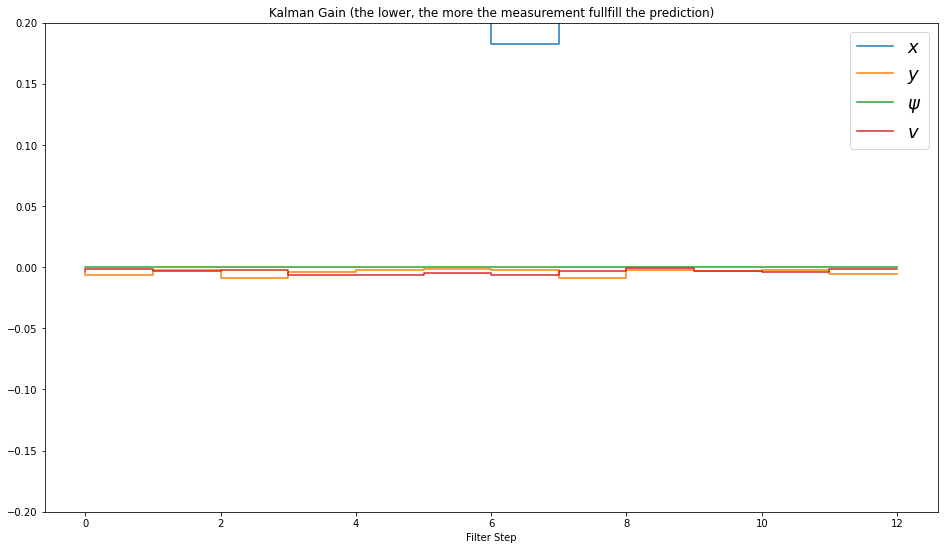

In [8]:
fig = plt.figure(figsize=(16,9))
plt.step(range(m),Kx, label='$x$')
plt.step(range(m),Ky, label='$y$')
plt.step(range(m),Kdx, label='$\psi$')
plt.step(range(m),Kdy, label='$v$')


plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(prop={'size':18})
plt.ylim([-0.2,0.2]);

### Uncertainties

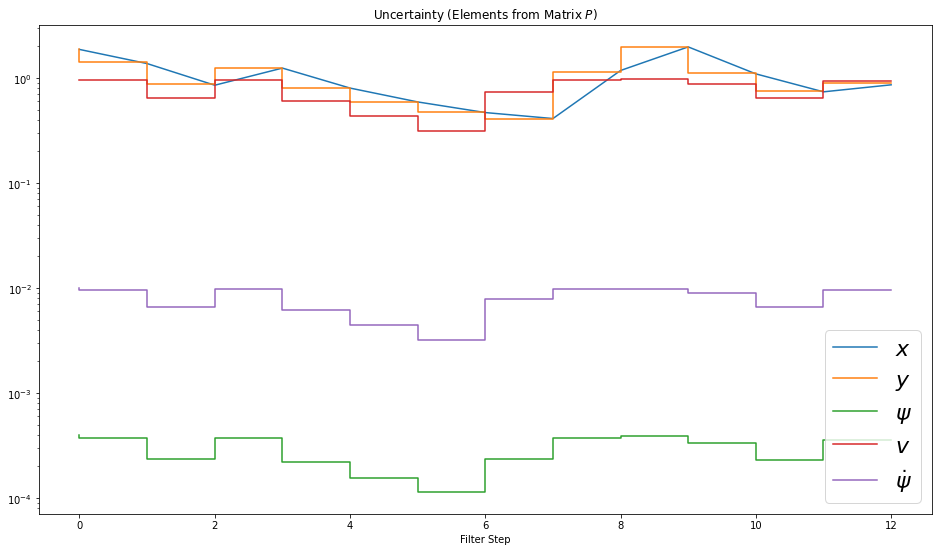

In [9]:

fig = plt.figure(figsize=(16,9))
plt.semilogy(range(m),Px, label='$x$')
plt.step(range(m),Py, label='$y$')
plt.step(range(m),Pdx, label='$\psi$')
plt.step(range(m),Pdy, label='$v$')
plt.step(range(m),Pddx, label='$\dot \psi$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

### Position x/y

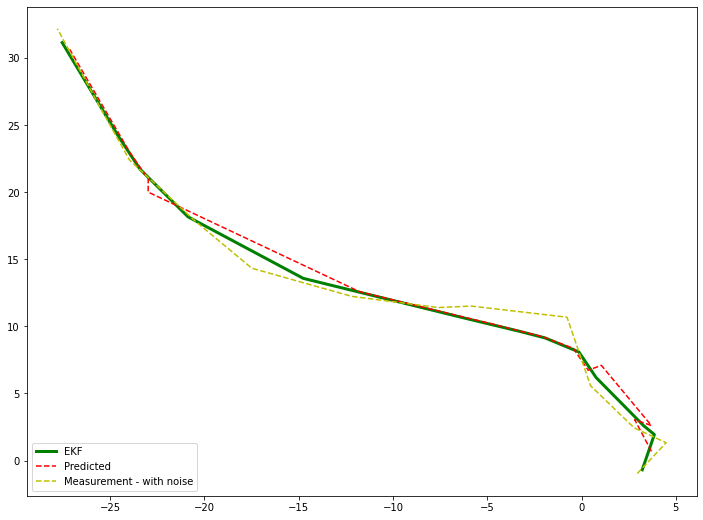

In [10]:
fig = plt.figure(figsize=(12,9))

x_measurement, y_measurement = measurements_mock[:, STATE_X_IDX], measurements_mock[:, STATE_Y_IDX]
x_noisy_measurement, y_noisy_measurement, x_predicted, y_predicted = np.array(
    [x_noisy_measurement, y_noisy_measurement, x_predicted, y_predicted],
    dtype='float64'
)

plt.plot(x0, x1, label='EKF', c='g', lw=3)
plt.plot(x_predicted, y_predicted, label='Predicted', c='r', lw=1.5, ls='--')

# plt.plot(x_measurement, y_measurement, label='Measurement - no noise', c='b', lw=1.5, ls=':')
plt.plot(x_noisy_measurement, y_noisy_measurement, label='Measurement - with noise', c='y', lw=1.5, ls='--')

plt.legend(loc="lower left")
plt.show()